# Data analysis
2019.03.18 - ?

In this file, I'll get to doing some linguistic analysis. Yay!

## Summary of code
- Read in CSV files made after cleaning the BALC corpus (CEPA essays, `cepa.csv` -> `cepa_df`, and lemmas from CEPA essays `filtered_balc_lemmas.csv` -> `cepa_lemmas`)
- Merge the lemmas from the CEPA essays and PELIC Arabic Level 3
    - Filter lemmas, removing any lemma that occurs less than 100 times in either corpus
    - Find mass and count nouns to utilize for analysis

### Set-up

In [1]:
import pandas as pd
import numpy as np
import re 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pprint            # to turn off pretty printing

Pretty printing has been turned OFF


In [2]:
# import cepa_df again
cepa_df = pd.read_csv("../private/cepa.csv", index_col=[0])
# import cepa_lemmas
cepa_lemmas = pd.read_csv("../private/filtered_balc_lemmas.csv", index_col=[0])

# check they've read in correctly
cepa_df.head()
cepa_lemmas.head()

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR,pos,lemmas
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...,Now I tell you why my worst holiday ever in th...,"['Now', 'I', 'tell', 'you', 'why', 'my', 'wors...",207,0.492754,"[(Now, 'RB'), (I, 'PRP'), (tell, 'VBP'), (you,...","['now', '-PRON-', 'tell', '-PRON-', 'why', '-P..."
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...,My worst holiday Last year I have just had the...,"['My', 'worst', 'holiday', 'Last', 'year', 'I'...",180,0.572222,"[(My, 'PRP$'), (worst, 'JJS'), (holiday, 'NN')...","['-PRON-', 'bad', 'holiday', 'last', 'year', '..."
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...,Every body in this life have a favourite posse...,Every body in this life have a favourite posse...,"['Every', 'body', 'in', 'this', 'life', 'have'...",229,0.445415,"[(Every, 'DT'), (body, 'NN'), (in, 'IN'), (thi...","['every', 'body', 'in', 'this', 'life', 'have'..."
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...,Every body have a lot ofpossessions in this li...,Every body have a lot ofpossessions in this li...,"['Every', 'body', 'have', 'a', 'lot', 'ofposse...",156,0.608974,"[(Every, 'DT'), (body, 'NN'), (have, 'VBP'), (...","['every', 'body', 'have', 'a', 'lot', 'ofposse..."
4,200611825,1,\t\t\t\tCEPA 1 200611825\n\n\n\nyou go in the ...,you go in the oman just had the perfect holida...,you go in the oman just had the perfect holida...,"['you', 'go', 'in', 'the', 'oman', 'just', 'ha...",27,0.629630,"[(you, 'PRP'), (go, 'VBP'), (in, 'IN'), (the, ...","['-PRON-', 'go', 'in', 'the', 'oman', 'just', ..."


,lemma,counts
0,the,13677
1,and,10492
2,be,10213
3,to,8692
4,in,6122


#### Review of CEPA essay makeup
Here, information about token count per level and number of texts per level can be found.

In [3]:
# let's look at the token count by level
cepa_df.groupby('Level')['token_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Level,,,,,,,,
1,276.0,50.409420,35.132618,0.0,24.75,43.0,65.00,199.0
2,292.0,94.287671,44.056346,10.0,59.75,86.5,123.00,310.0
3,250.0,138.056000,47.681305,38.0,105.25,134.0,164.50,316.0
4,297.0,200.373737,50.291163,5.0,167.00,200.0,232.00,343.0
5,299.0,231.862876,51.702926,97.0,193.50,227.0,272.00,397.0
6,250.0,246.748000,53.685426,116.0,210.00,243.0,281.75,392.0


In [4]:
# import seaborn and plt
import seaborn as sns
import matplotlib as plt

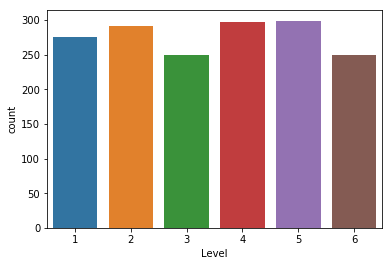

In [5]:
fig1 = sns.countplot(x="Level", data=cepa_df)

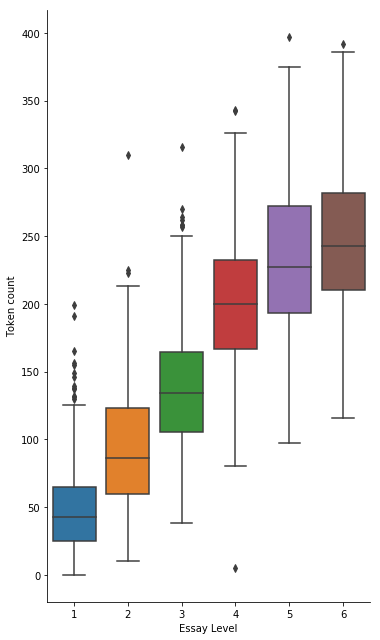

In [6]:
fig2 = sns.catplot(x='Level', y='token_count', kind='box', data=cepa_df, height=9, aspect=0.6)
fig2.set_axis_labels(x_var="Essay Level", y_var="Token count")

#### Let's fine-tune a little
In this section, I'll start filtering some of the data out (concerning CEPA)

In [7]:
# we'll use filters, informed by our quick perusal through PELIC 
filters = (cepa_df.Level >= 2) & (cepa_df.token_count >= 10) & (cepa_df.token_count <= 400)

In [8]:
# apply filters and get a dataframe of possible target essays from CEPA
cepa_target = cepa_df[filters]
cepa_target.head()

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR,pos,lemmas
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...,Now I tell you why my worst holiday ever in th...,"['Now', 'I', 'tell', 'you', 'why', 'my', 'wors...",207,0.492754,"[(Now, 'RB'), (I, 'PRP'), (tell, 'VBP'), (you,...","['now', '-PRON-', 'tell', '-PRON-', 'why', '-P..."
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...,My worst holiday Last year I have just had the...,"['My', 'worst', 'holiday', 'Last', 'year', 'I'...",180,0.572222,"[(My, 'PRP$'), (worst, 'JJS'), (holiday, 'NN')...","['-PRON-', 'bad', 'holiday', 'last', 'year', '..."
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...,Every body in this life have a favourite posse...,Every body in this life have a favourite posse...,"['Every', 'body', 'in', 'this', 'life', 'have'...",229,0.445415,"[(Every, 'DT'), (body, 'NN'), (in, 'IN'), (thi...","['every', 'body', 'in', 'this', 'life', 'have'..."
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...,Every body have a lot ofpossessions in this li...,Every body have a lot ofpossessions in this li...,"['Every', 'body', 'have', 'a', 'lot', 'ofposse...",156,0.608974,"[(Every, 'DT'), (body, 'NN'), (have, 'VBP'), (...","['every', 'body', 'have', 'a', 'lot', 'ofposse..."
6,200608959,5,\t\t\t\tCEPA 5 200608959\n\n\n\nI have just ha...,I have just had the perfect and the best holid...,I have just had the perfect and the best holid...,"['I', 'have', 'just', 'had', 'the', 'perfect',...",277,0.440433,"[(I, 'PRP'), (have, 'VBP'), (just, 'RB'), (had...","['-PRON-', 'have', 'just', 'have', 'the', 'per..."


In [9]:
# let's see how many essays we have left and some stats
cepa_target.groupby('Level')['token_count'].describe()

# so we only lost 1 essays from level 4

,count,mean,std,min,25%,50%,75%,max
Level,,,,,,,,
2,292.0,94.287671,44.056346,10.0,59.75,86.5,123.00,310.0
3,250.0,138.056000,47.681305,38.0,105.25,134.0,164.50,316.0
4,296.0,201.033784,49.070812,80.0,167.00,200.5,232.00,343.0
5,299.0,231.862876,51.702926,97.0,193.50,227.0,272.00,397.0
6,250.0,246.748000,53.685426,116.0,210.00,243.0,281.75,392.0


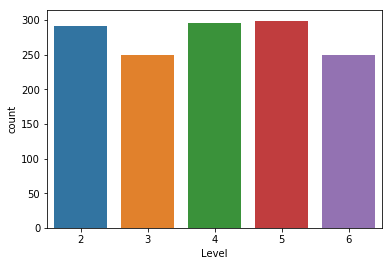

In [10]:
fig3 = sns.countplot(x="Level", data=cepa_target)

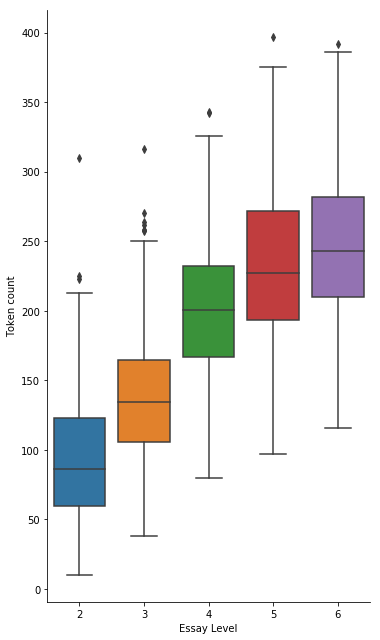

In [11]:
fig3 = sns.catplot(x='Level', y='token_count', kind='box', data=cepa_target, height=9, aspect=0.6)
fig3.set_axis_labels(x_var="Essay Level", y_var="Token count")

### Lemma lists and noun choice
Now we'll compare lemmas across the two corpora, with respect to Arabic L1 speakers.

In [12]:
# Alan did lemma counts on PELIC -- let's reference this. Thanks, Alan!
pelic_lemmas = pd.read_csv('/Users/elenacimino/Alan-Workspace/FREQ_Lists/Arabic_Level_3_FREQ2000_AAAL.csv', 
                           index_col=[0])
pelic_lemmas.head()

,lemma,count
1,the,46073.0
2,be,41895.0
3,i,34769.0
4,to,34572.0
5,and,25170.0


In [13]:
# we'll merge the two dfs so we can get the mutual lemmas
lemmas = pd.merge(cepa_lemmas, pelic_lemmas, on=['lemma'])

# what do we have
lemmas.head()

,lemma,counts,count
0,the,13677,46073.0
1,and,10492,25170.0
2,be,10213,41895.0
3,to,8692,34572.0
4,in,6122,23965.0


In [14]:
lemmas

,lemma,counts,count
0,the,13677,46073.0
1,and,10492,25170.0
2,be,10213,41895.0
3,to,8692,34572.0
4,in,6122,23965.0
5,go,4995,4774.0
6,a,3913,21613.0
7,have,2823,14836.0
8,that,2504,8401.0
9,of,2411,17055.0


In [15]:
# Let's throw out any lemmas that occur less than 100 times in either corpus
lemmas[lemmas.counts >= 50 & lemmas.count >= 100]

# oh, because count is a method, we won't be able to do it like this... let's rename the 'count' columns

TypeError: unsupported operand type(s) for &: 'int' and 'method'

In [16]:
lemmas.columns=['lemma', 'counts_cepa', 'counts_pelic']
lemmas.head()

,lemma,counts_cepa,counts_pelic
0,the,13677,46073.0
1,and,10492,25170.0
2,be,10213,41895.0
3,to,8692,34572.0
4,in,6122,23965.0


In [17]:
# I'll give a little more wiggle room to the CEPA counts, since that corpus is much smaller
poss_targets = lemmas[(lemmas.counts_cepa >= 50) & (lemmas.counts_pelic >= 100)]
poss_targets

,lemma,counts_cepa,counts_pelic
0,the,13677,46073.0
1,and,10492,25170.0
2,be,10213,41895.0
3,to,8692,34572.0
4,in,6122,23965.0
5,go,4995,4774.0
6,a,3913,21613.0
7,have,2823,14836.0
8,that,2504,8401.0
9,of,2411,17055.0


In [18]:
targets = list(poss_targets.lemma)
targets

['the', 'and', 'be', 'to', 'in', 'go', 'a', 'have', 'that', 'of', 'with', 'very', 'holiday', 'so', 'for', 'see', 'there', 'not', 'because', 'family', 'do', 'like', 'this', 'can', 'day', 'good', 'but', 'time', 'when', 'all', 'after', 'bad', 'father', 'many', 'on', 'friend', 'one', 'place', 'thing', 'at', 'play', 'people', 'take', 'about', 'will', 'some', 'last', 'happy', 'from', 'ever', 'spend', 'sister', 'nice', 'get', 'come', 'summer', 'wonderful', 'mother', 'also', 'brother', 'enjoy', 'car', 'love', 'film', 'back', 'then', 'visit', 'al', 'what', 'as', 'life', 'want', 'make', 'park', 'by', 'much', 'hotel', 'movie', 'first', 'just', 'really', 'home', 'travel', 'eat', 'country', 'big', 'tell', 'most', 'beautiful', 'which', 'think', 'weekend', 'who', 'stay', 'know', 'every', 'where', 'year', 'city', 'week', 'start', 'sea', 'feel', 'two', 'next', 'or', 'other', 'buy', 'lot', 'shopping', 'call', 'could', 'out', 'more', 'mall', 'food', 'say', 'help', 'i', 'no', 'house', 'watch', 'weather', 

In [19]:
# import stopwords from NLTK
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words

# refining targets
for targ in targets:
    if targ in stop_words:
        targets.remove(targ)    # remove stop words from targets
    elif targ.isalpha() == False:
        targets.remove(targ)    # remove non-alphabetic words from targets
    elif len(targ) < 2:
        targets.remove(targ)    # remove any words less than 2 charactersfrom targets
        
len(targets)

{'theirs', 'for', 'under', 'not', "didn't", 'couldn', 'hadn', 'my', 'after', 'didn', 'because', 'here', "aren't", 'any', 'll', 'has', 'hers', 'ain', "don't", "hasn't", 'her', 'of', "haven't", "wouldn't", "you're", 'no', 'then', 'can', 'he', 'herself', 'had', 'how', 'don', 'was', 'which', 'it', 'same', 'further', "you've", 'if', 'very', 'should', 'shouldn', 'above', 'more', 'or', 'weren', 'our', 'what', 'there', "shan't", "she's", 'they', 'between', 'do', 'few', 'wouldn', 're', 'doing', "mustn't", 'myself', 'once', 'me', 'who', "shouldn't", "doesn't", 'needn', 'off', 'down', 'i', 'where', 'yourselves', 'did', "wasn't", 'to', 'too', "it's", 'when', 'd', 'ours', 'have', 'aren', 'shan', "weren't", 's', 'she', 'we', 'ourselves', 'the', 've', 'so', 'now', 'in', 'with', "you'll", 'just', 'an', "you'd", 'are', 'as', 'being', 'won', 'again', 'why', 'only', 'own', 'against', 'themselves', 'ma', 'were', 'you', 'mightn', 'each', 'yours', 'all', 'a', 'other', 'hasn', 'their', 'them', 'and', 'wasn',

270

So there are 270 possible targets now... Let's see if we can find any abstract and concrete nouns in there (we definitely will be able to).

In [20]:
targets

['and', 'to', 'go', 'have', 'of', 'very', 'holiday', 'for', 'see', 'not', 'family', 'like', 'can', 'day', 'good', 'time', 'all', 'bad', 'father', 'many', 'friend', 'one', 'place', 'thing', 'play', 'people', 'take', 'will', 'last', 'happy', 'ever', 'spend', 'sister', 'nice', 'get', 'come', 'summer', 'wonderful', 'mother', 'also', 'brother', 'enjoy', 'car', 'love', 'film', 'back', 'visit', 'al', 'as', 'life', 'want', 'make', 'park', 'much', 'hotel', 'movie', 'first', 'really', 'home', 'travel', 'eat', 'country', 'big', 'tell', 'beautiful', 'think', 'weekend', 'stay', 'know', 'every', 'year', 'city', 'week', 'start', 'sea', 'feel', 'two', 'next', 'other', 'buy', 'lot', 'shopping', 'call', 'could', 'more', 'mall', 'food', 'say', 'help', 'no', 'house', 'watch', 'weather', 'would', 'live', 'look', 'school', 'fun', 'decide', 'any', 'shop', 'use', 'up', 'give', 'finally', 'great', 'arrive', 'room', 'find', 'sleep', 'animal', 'world', 'hour', 'way', 'football', 'old', 'story', 'work', 'happen',

In [21]:
# eyeballing and putting nouns into a count, mass, and 'flexible' list 
count = ['father', 'friend', 'mother', 'sister', 'mother', 'park', 'hotel', 'movie', 'woman', 
         'exam', 'place', 'thing', 'brother', 'park', 'hotel', 'movie', 'country', 'weekend', 
         'year', 'city', 'week', 'mall', 'house', 'shop', 'room', 'world', 'animal', 'hour', 
         'way', 'football', 'story', 'trip', 'beach', 'game', 'airport', 'topic', 'uncle', 
        'book', 'child', 'computer', 'girl', 'hospital', 'plane', 'book', 'hospital', 'plane', 
        'problem', 'vacation', 'parent', 'name', 'gift', 'wish', 'person', 'body', 'tree', 'show', 
        'picture', 'idea', 'reason', 'street', 'change', 'desert', 'face', 'boy', 'activity', 'doctor', 'exam', 
         'dream', 'area', 'head', 'bed', 'woman', 'phone', 'drink', 'view']

mass = ['time', 'land', 'shopping', 'food', 'weather', 'sleep', 'work', 'hope', 'water', 'rest', 'rain', 'egypt',
       'english', 'money', 'sea']

flexible = ['holiday', 'family', 'day', 'people', 'summer', 'car', 'love', 'film', 'life', 
            'home', 'country', 'help', 'school', 'man', 'night', 'plan', 'lunch', 'dinner', 
           'night', 'morning', 'month', 'fish', 'sport']

In [22]:
# making some filters
ct_filter = (lemmas.lemma.isin(count))
ms_filter = (lemmas.lemma.isin(mass))
fl_filter = (lemmas.lemma.isin(flexible))

In [23]:
# creating individualized df's for count, mass, and ambiguous nouns
count_nouns = lemmas[ct_filter]
mass_nouns = lemmas[ms_filter]
either_nouns = lemmas[fl_filter]

Let's take a closer look, shall we?

In [24]:
count_nouns

,lemma,counts_cepa,counts_pelic
32,father,861,894.0
35,friend,844,2441.0
37,place,770,1883.0
38,thing,741,2637.0
51,sister,572,412.0
57,mother,526,425.0
59,brother,486,621.0
73,park,431,247.0
76,hotel,421,292.0
77,movie,412,938.0


In [25]:
count_nouns[(count_nouns.counts_cepa >= 65) & (count_nouns.counts_cepa <= 300)]

,lemma,counts_cepa,counts_pelic
116,mall,268,159.0
122,house,260,1420.0
136,shop,218,101.0
145,room,196,1090.0
148,animal,188,387.0
149,world,188,1129.0
150,hour,187,431.0
151,way,185,1376.0
152,football,185,152.0
154,story,182,254.0


In [26]:
mass_nouns

,lemma,counts_cepa,counts_pelic
27,time,984,3595.0
103,sea,301,285.0
111,shopping,282,222.0
117,food,267,3829.0
124,weather,253,685.0
147,sleep,188,361.0
155,work,179,2194.0
172,hope,155,317.0
189,water,125,583.0
262,rest,84,127.0


In [27]:
either_nouns

,lemma,counts_cepa,counts_pelic
12,holiday,2067,159.0
19,family,1261,2054.0
24,day,1028,2257.0
41,people,724,4280.0
55,summer,553,304.0
61,car,485,1845.0
62,love,483,951.0
63,film,471,108.0
70,life,444,1984.0
81,home,398,1693.0


In [28]:
filters = ((lemmas.lemma.isin(count)) | (lemmas.lemma.isin(mass))) & \
(lemmas.counts_cepa >= 50)

In [29]:
def nounType(word):
    if word in list(count_nouns.lemma):
        return 'count'
    elif word in list(mass_nouns.lemma):
        return 'mass'
    else: return 'ambi'

lemmas = lemmas[filters]
lemmas['type'] = lemmas.lemma.apply(nounType)
lemmas

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,lemma,counts_cepa,counts_pelic,type
27,time,984,3595.0,mass
32,father,861,894.0,count
35,friend,844,2441.0,count
37,place,770,1883.0,count
38,thing,741,2637.0,count
51,sister,572,412.0,count
57,mother,526,425.0,count
59,brother,486,621.0,count
73,park,431,247.0,count
76,hotel,421,292.0,count


In [30]:
actual_targets = ['egypt', 'sea', 'shopping', 'weather', 'water', 'rain', 
                  'football', 'beach', 'hospital', 'mall', 'weekend', 'book']

In [31]:
filters = (lemmas.lemma.isin(actual_targets))
actual_targets_df = lemmas[filters]
actual_targets_df

,lemma,counts_cepa,counts_pelic,type
91,weekend,347,399.0,count
103,sea,301,285.0,mass
111,shopping,282,222.0,mass
116,mall,268,159.0,count
124,weather,253,685.0,mass
152,football,185,152.0,count
163,beach,165,387.0,count
189,water,125,583.0,mass
194,book,121,685.0,count
208,hospital,115,209.0,count


In [32]:
actual_targets_df.describe()

,counts_cepa,counts_pelic
count,12.000000,12.000000
mean,192.333333,340.750000
std,94.418154,206.647317
min,72.000000,139.000000
25%,119.500000,177.750000
50%,175.000000,253.500000
75%,271.500000,445.000000
max,347.000000,685.000000


In [33]:
# write this out to a csv file in case it's needed later
actual_targets_df.to_csv('chosen_targets.csv')

### Nouns in the CEPA essays
Let's check and make sure we have some kind of distribution across different for these nouns.

In [34]:
cepa_df[cepa_df.lemmas.str.contains('sea') == True].groupby('Level')['token_count'].describe()
cepa_df[cepa_df.lemmas.str.contains('egypt') == True].groupby('Level')['token_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Level,,,,,,,,
1,16.0,93.125000,44.612218,23.0,65.50,83.0,119.25,199.0
2,43.0,103.976744,45.484423,45.0,66.50,102.0,126.50,223.0
3,53.0,137.226415,43.667292,57.0,108.00,135.0,160.00,264.0
4,56.0,210.178571,44.469850,114.0,188.75,211.5,239.00,312.0
5,46.0,242.717391,42.842172,172.0,212.75,238.0,276.50,345.0
6,43.0,253.790698,49.124506,164.0,219.50,251.0,293.00,348.0


,count,mean,std,min,25%,50%,75%,max
Level,,,,,,,,
1,1.0,102.000000,NaN,102.0,102.00,102.0,102.0,102.0
3,4.0,118.250000,33.599355,82.0,94.75,118.0,141.5,155.0
4,7.0,192.428571,31.111933,130.0,188.00,197.0,207.5,229.0
5,8.0,261.000000,41.768067,195.0,232.75,275.5,290.5,307.0
6,7.0,232.857143,39.010377,176.0,204.00,247.0,261.0,277.0


In [35]:
for targ in actual_targets:
    print(targ+":")
    print(cepa_df[cepa_df.lemmas.str.contains(targ) == True].groupby('Level')['token_count'].describe())
    print()

egypt:
       count        mean        std    min     25%    50%    75%    max
Level                                                                  
1        1.0  102.000000        NaN  102.0  102.00  102.0  102.0  102.0
3        4.0  118.250000  33.599355   82.0   94.75  118.0  141.5  155.0
4        7.0  192.428571  31.111933  130.0  188.00  197.0  207.5  229.0
5        8.0  261.000000  41.768067  195.0  232.75  275.5  290.5  307.0
6        7.0  232.857143  39.010377  176.0  204.00  247.0  261.0  277.0

sea:
       count        mean        std    min     25%    50%     75%    max
Level                                                                   
1       16.0   93.125000  44.612218   23.0   65.50   83.0  119.25  199.0
2       43.0  103.976744  45.484423   45.0   66.50  102.0  126.50  223.0
3       53.0  137.226415  43.667292   57.0  108.00  135.0  160.00  264.0
4       56.0  210.178571  44.469850  114.0  188.75  211.5  239.00  312.0
5       46.0  242.717391  42.842172  172.0  2

In [36]:
spanish_lemmas = pd.read_csv('/Users/elenacimino/Alan-Workspace/FREQ_Lists/SPAN_Level3_FREQ2000_Lema.csv', 
                           index_col=[0])
korean_lemmas = pd.read_csv('/Users/elenacimino/Alan-Workspace/FREQ_Lists/Korean_Level_3_FREQ3000_AAAL.csv',
                           index_col=[0])

spanish_lemmas.head()
korean_lemmas.head()

,lemma,count,per mil,totall words
NaN,NaN,NaN,50.372758,19852.0
1.0,i,54352.0,NaN,NaN
2.0,the,53043.0,NaN,NaN
3.0,be,51531.0,NaN,NaN
4.0,to,31332.0,NaN,NaN


,lemma,count
1,be,44083
2,i,35716
3,the,33163
4,to,30623
5,a,29139


In [37]:
for targ in actual_targets:
    if targ not in list(spanish_lemmas.lemma):
        print(targ)

shopping
rain


In [38]:
any(spanish_lemmas.lemma.str.contains('shop') == True)
any(spanish_lemmas.lemma.str.contains('rain') == True)
spanish_lemmas[(spanish_lemmas.lemma.str.contains('shop') | spanish_lemmas.lemma.str.contains('rain'))]

True

True

,lemma,count,per mil,totall words
432.0,train,252.0,NaN,NaN
436.0,shop,252.0,NaN,NaN
557.0,workshop,201.0,NaN,NaN
896.0,brainstorm,101.0,NaN,NaN
1056.0,bookshop,101.0,NaN,NaN
1760.0,brain,50.0,NaN,NaN


In [39]:
for targ in actual_targets:
    if targ not in list(korean_lemmas.lemma):
        print(targ)